<a href="https://colab.research.google.com/github/guiguilhermegui/TF/blob/main/modelo_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Checkout www.pygimli.org for more examples
#!pip install pygimli tetgen


# Hydrogeophysical modelling

Coupled hydrogeophysical modelling example. This essentially represents the
forward modelling step of the example presented in section 3.2 of the [pyGIMLi
paper](http://www.sciencedirect.com/science/article/pii/S0098300417300584/pdfft?md5=44253eaacd5490e3fb32210671672496&pid=1-s2.0-S0098300417300584-main.pdf).


Create geometry definition for the modelling domain



In [2]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert
import pygimli.physics.petro as petro
from pygimli.physics import ERTManager

In [3]:
### Parametros
## Espaciais
# Espaciais dos furos
bores = [-20, -15, -10, -5, 0, 5, 10, 15]                       # Posição central dos furos
prof_poco=-0.9
altura_poco= 0.1
raio_poco=0.35   #precisa ser decimal Ex:"3.00001"

# Espaciais do Terreno
box_esq=-30
box_dir=30
box_top=0.01
box_bottom=-20

# Espaciais discretização de células
mesh_area=0.4               # area da mesh em metros^2
mesh_quality=30             # qualidade da mesh evitar valores acima de 33 por questões de performance

## Hidráulicos do meio
# Condutividade Hidráulica em m/s 
K_poco = 1e4       #poço
K_mundo1 = 1e-9    #latossolo
K_mundo2 = 1e3     #fratura 
K_mundo3 = 1e-3    #rocha
#Marcador de região do modelo
Mk_poco = 1       #poço
Mk_mundo1 = 2    #latossolo     
Mk_mundo2 = 3    #fratura 
Mk_mundo3 = 4    #rocha
# Resumir Condutividades hidráulicas em uma variável só
kMap = [[Mk_mundo1, K_mundo1],  [Mk_poco, K_poco]]   #Use [[RegionMarker, ConductivityValue], ...]
# Propriedades do meio poroso ADV
phi = 0.3                   # Porosidade meio
D = 0.01                    # Coeficiente de dispersão m^2/s


## Traçador                  # Condutividade elétrica da água em S/m
sigma_a = -0.00031            
sigma_bx = 0.19330           # Termos da Eq. de Resistência/concentração = A+bx   
TracerCon = 13.27            # Concentração em g/l
cementation_exponent = 1.1,  # Exponente de cimentação para a resistividade do solo
res_water = 10000            # Resistividade da água em Ohm.m

# Resistividade do meio em Ohm.m
Layer0=box_top
RLayer0=300
Layer1=-2                    # Prof. da camada 1
RLayer1=150                  # Resistividade da camada 1
Layer2=-8                    # Prof. da camada 2
RLayer2=4464                 # Resistividade da camada 2
Layer3=-24                   # Prof. da camada 3
RLayer3=3300                 # Resistividade da camada 4

# Configuração ERT 
ERT_dist= 600                # Distância total dos eletrodos em m
ERT_elecs = 60               # Quantidade de eletrodos
ERT_spac = 10                # Espaçamento entre os eletrodos em m
ERT_Array = 'dd'             # wn, ws, wa, wb, dd, pd, pp, grad 

y_limit = 40                 # Set the Y-axis limit to cut off below DD12



# Temporais
TimeSimu_days = 1                     # Tempo de simulação em dias  
TimeSimu_sec = TimeSimu_days*24*60*60   # Tempo de simulação em seg  
TimeSimu_steps = 30*60                  # Quantidade de passos pra simulação
number_of_timesERT = 12        # Número de vezes que a simulação de ERT é executada


""" Cálculos Espaciais relativos do furo """
esq = '.' + f'{raio_poco:.2f}'.split('.')[1]
dir = '.' + f'{1 - raio_poco:.2f}'.split('.')[1]#print(f'raio_poco={raio_poco:.2f} esq={esq} dir={dir}')

""" Cálculo Espaçamento dos eletrodos """
elecs = np.linspace(-ERT_dist/2, ERT_dist/2, ERT_elecs)


""" Cálculo tempo de simulação """
t = pg.utils.grange(0, TimeSimu_sec, n=TimeSimu_steps)

In [4]:
## EDP - Condições de Contorno - potencial hidráulico 
basemundo_2 = 0.0             # Definir valores de fronteira pro potencial hidráulico  # fronteiras 1top, 2lat,3_fundo,4latmundo,-2basemundo,-1topomundo
topo7 = 0.9
#laterais8 = h202             # Defina a altura da água nas laterais
#fundo9 = 0.9   #h20          # Defina a altura da água no poço
pBound = {"Dirichlet": {-2: basemundo_2, -1: topo7}} #{marker: value, ...} #Dirichlet, Neumann, Robin #pBound = pBound.append("Neumann":{2: laterais8, 3:fundo9})



" node = [] # Print nodes\nfor i, n in enumerate(geom.nodes()):\n    ax.text(n.x(), n.y(), str(i), color='blue', size=10)\n    node.append([i, n.x(), n.y()]) "

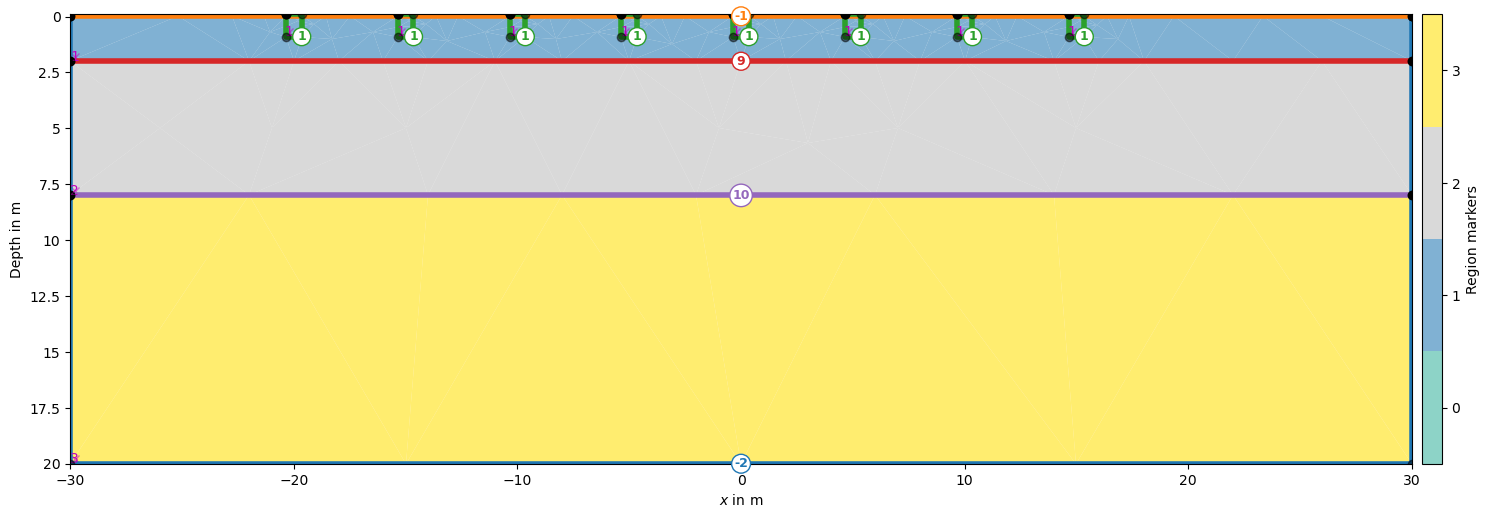

In [5]:
# Create a 2D world box
world = mt.createWorld(start=[box_esq, box_top], end=[box_dir, box_bottom], WorldMarker=False, layers=[Layer1,Layer2]) 

# Create boreholes
poco = []
for pos in bores:
    poco.append(mt.createRectangle(start=[pos - raio_poco, altura_poco], end=[pos + raio_poco,prof_poco],)) #marker=42, isHole=True, boundaryMarker=12))
boreholes = poco[0]
for borehole in poco[1:]:
    boreholes = boreholes + borehole


# Create geometry of model
geom = world + boreholes
#pg.show(mesh)

# Create figure
ax, _ = pg.show(geom, markers=True, orientation='vertical', figsize=(15, 8), showNodes=True, showMesh=True)

""" node = [] # Print nodes
for i, n in enumerate(geom.nodes()):
    ax.text(n.x(), n.y(), str(i), color='blue', size=10)
    node.append([i, n.x(), n.y()]) """



In [6]:
print(pBound)
node = geom.nodes()
print(node)  # This will print the object reference again


for i in range(0, len(node), 4):# Print 4 lists of nodes per line, very useful for rectangles models
    print('nodes' + str(node[i:i+4]))
print()
print(geom.nodes())


{'Dirichlet': {-2: 0.0, -1: 0.9}}
nodes[	ID: 0, Marker: 0	RVector3: (-30.0, 0.01, 0.0)
, 	ID: 1, Marker: 0	RVector3: (-30.0, -2.0, 0.0)
, 	ID: 2, Marker: 0	RVector3: (-30.0, -8.0, 0.0)
, 	ID: 3, Marker: 0	RVector3: (-30.0, -20.0, 0.0)
]
nodes[	ID: 4, Marker: 0	RVector3: (30.0, -20.0, 0.0)
, 	ID: 5, Marker: 0	RVector3: (30.0, -8.0, 0.0)
, 	ID: 6, Marker: 0	RVector3: (30.0, -2.0, 0.0)
, 	ID: 7, Marker: 0	RVector3: (30.0, 0.01, 0.0)
]
nodes[	ID: 8, Marker: 0	RVector3: (-20.35, 0.1, 0.0)
, 	ID: 9, Marker: 0	RVector3: (-20.35, -0.9, 0.0)
, 	ID: 10, Marker: 0	RVector3: (-19.65, -0.9, 0.0)
, 	ID: 11, Marker: 0	RVector3: (-19.65, 0.1, 0.0)
]
nodes[	ID: 12, Marker: 0	RVector3: (-15.35, 0.1, 0.0)
, 	ID: 13, Marker: 0	RVector3: (-15.35, -0.9, 0.0)
, 	ID: 14, Marker: 0	RVector3: (-14.65, -0.9, 0.0)
, 	ID: 15, Marker: 0	RVector3: (-14.65, 0.1, 0.0)
]
nodes[	ID: 16, Marker: 0	RVector3: (-10.35, 0.1, 0.0)
, 	ID: 17, Marker: 0	RVector3: (-10.35, -0.9, 0.0)
, 	ID: 18, Marker: 0	RVector3: (-9.65, -0.9, 

In [7]:
print(geom.boundaries)

<bound method boundaries of Mesh: Nodes: 40 Cells: 0 Boundaries: 42>


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

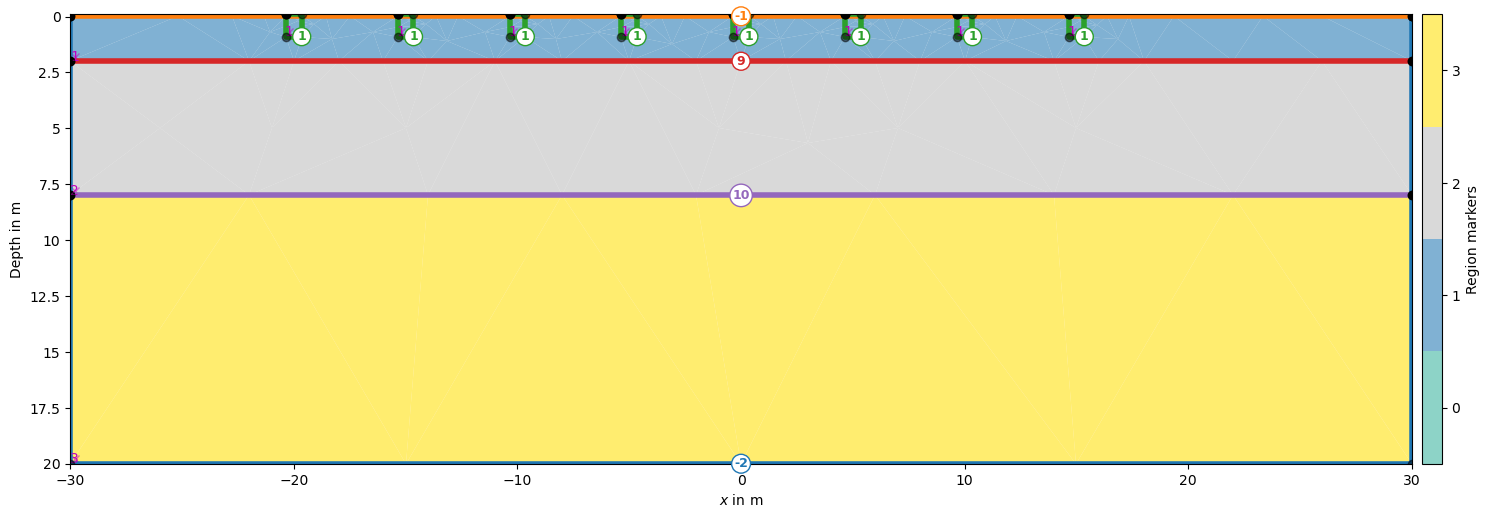

In [8]:
# Marcadores de Fronteira dos buracos

bottom_boundaries = [boundary.id() for boundary in geom.boundaries() if boundary.center()[1] ==prof_poco]
side_boundaries = [boundary.id() for boundary in geom.boundaries() if boundary.center()[0] ==box_esq] + [boundary.id() for boundary in geom.boundaries() if boundary.center()[0] ==box_dir]


""" # Atribuição da numeracao das fronteiras boreholes
def pos(count):
    return pg.pos(node[count][1], node[count][2])
for a in range(len(bottom_boundaries)):
    geom.createEdge(geom.node(bottom_boundaries[a]), geom.node(right_boundaries[a]), marker=9)

for a in range(len(right_boundaries)):
    geom.createEdge(geom.node(top_boundaries[a]), geom.node(right_boundaries[a]), marker=8)

for a in range(len(left_boundaries)):
    geom.createEdge(geom.node(bottom_boundaries[a]), geom.node(left_boundaries[a]), marker=8)
for a in range(len(top_boundaries)):
    geom.createEdge(geom.node(left_boundaries[a]), geom.node(top_boundaries[a]), marker=7)
 """
pg.show(geom, label='Boundary marker', showNodes=True,markers=True, showMesh=True, figsize=(15, 8), orientation='vertical' )

(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

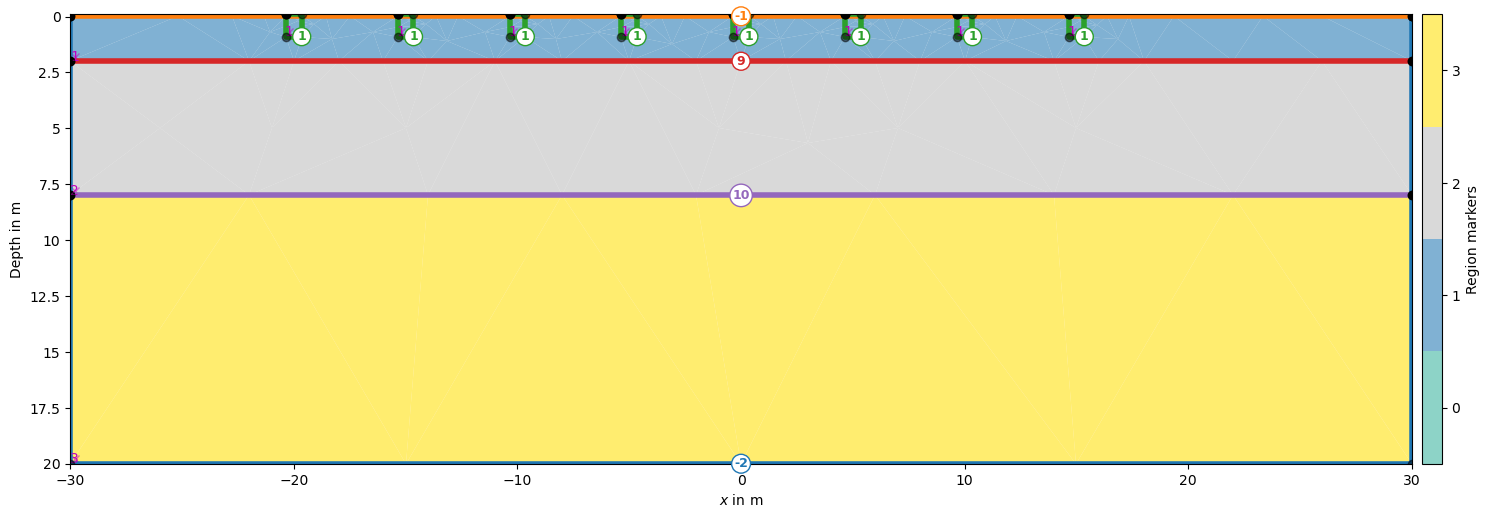

In [9]:

# Marcadores de Fronteira dos Terreno 3 Camadas

pg.show(geom, label='Boundary marker', showNodes=True,markers=True, showMesh=True, figsize=(15, 8), orientation='vertical' )

Fluid flow in a porous medium of slow non-viscous and non-frictional hydraulic
movement is governed by Darcy's Law according to:

\begin{align}K^{-1}\mathbf{v} + \nabla p & = 0 \\
   \nabla \cdot \mathbf{v} & = 0\\
   \text{leading}\,\,\text{to}\,\,
   \nabla\cdot(K \nabla p) & = 0 \quad \text{on} \quad\Omega\end{align}

We begin by defining isotropic values of hydraulic conductivity $K$ and
mapping these to each mesh cell:



Mesh:  Mesh: Nodes: 2721 Cells: 5166 Boundaries: 7886
Assembling time:  0.0188988
Solving time:  0.0049888


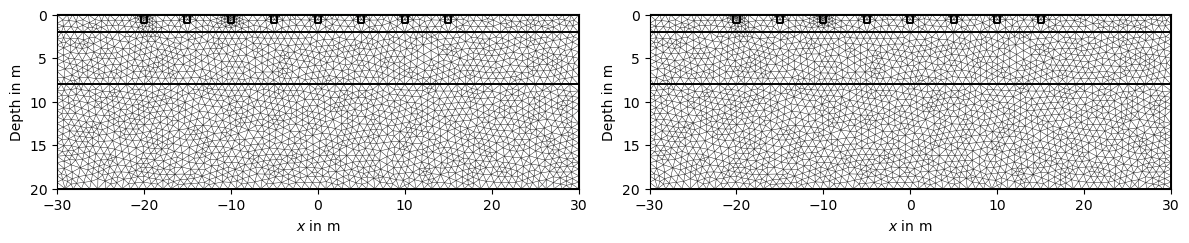

(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

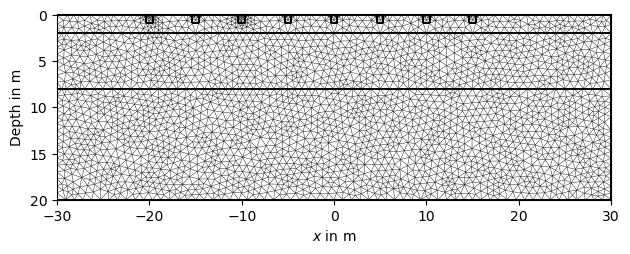

In [10]:
## Resolução K  por Darcy
# Map conductivity value per region to each cell in the given mesh

mesh = mt.createMesh(geom, quality=mesh_quality, area=mesh_area, smooth=[1, 10])
K = pg.solver.parseMapToCellArray(kMap, mesh)

#pg.show(mesh, rhoa=K, label='Hydraulic conductivity $K$ in m/s', cMin=1e-10, cMax=1e12, logScale=True, grid=True)

# Resolução da discretização do modelo de potencial hidráulico
#p = np.random.rand(mesh.cellCount())   # Teste aleatorio

# Resolver o modelo de potencial hidráulico
p = pg.solver.solveFiniteElements(mesh, a=K, bc=pBound, verbose=True)#stats=True)

# OK
# Atualizar a visualização ou armazenar resultados
fig, axs = plt.subplots(1,2,figsize=(12, 12))
pg.show(mesh, rhoa=K, label='Condutividade Hidráulica $K$ em m/s', cMap= 'Viridis',logScale=True, ax=axs[0],orientation='horizontal')
pg.show(mesh, rhoa=p, label='Potencial Hidráulico', cMin=np.min(p), cMax=np.max(p), ax=axs[1],orientation='horizontal')
plt.show()
pg.show(mesh,rhoa=K)

The problem further boundary conditions of the hydraulic potential. We use
$p=p_0=0.75$ m on the left and $p=0$ on the right boundary of the modelling
domain, equaling a hydraulic gradient of 1.75%.



\begin{split}c \frac{\partial u}{\partial t} & = \nabla\cdot(a \nabla u)
+ b u + f(\mathbf{r},t)~~|~~\Omega_{\text{Mesh}}\\
u & = h~~|~~\Gamma_{\text{Dirichlet}}\\
a\frac{\partial u}{\partial \mathbf{n}} & =
g~~|~~\Gamma_{\text{Neumann}}\\
\alpha u + \beta\frac{\partial u}{\partial \mathbf{n}} & =
\gamma~~|~~\Gamma_{\text{Robin}}\\
\frac{\partial u}{\partial \mathbf{n}} & =
\alpha(u_0-u)~~|~~\Gamma_{\text{Robin}}\end{split}

https://www.pygimli.org/pygimliapi/_generated/pygimli.solver.html#pygimli.solver.solveFiniteElements

We can now call the finite element solver with the generated mesh, hydraulic
conductivity and the boundary condition. The sought hydraulic velocity
distribution can then be calculated as the gradient field of
$\mathbf{v}=-\nabla p$ and visualized using the generic `pg.show()` function.



In [11]:
# Resolução da velocidade como o neg. do grad. do Pot. Hid.
vel = -pg.solver.grad(mesh, p) * np.asarray([K, K, K]).T #4D


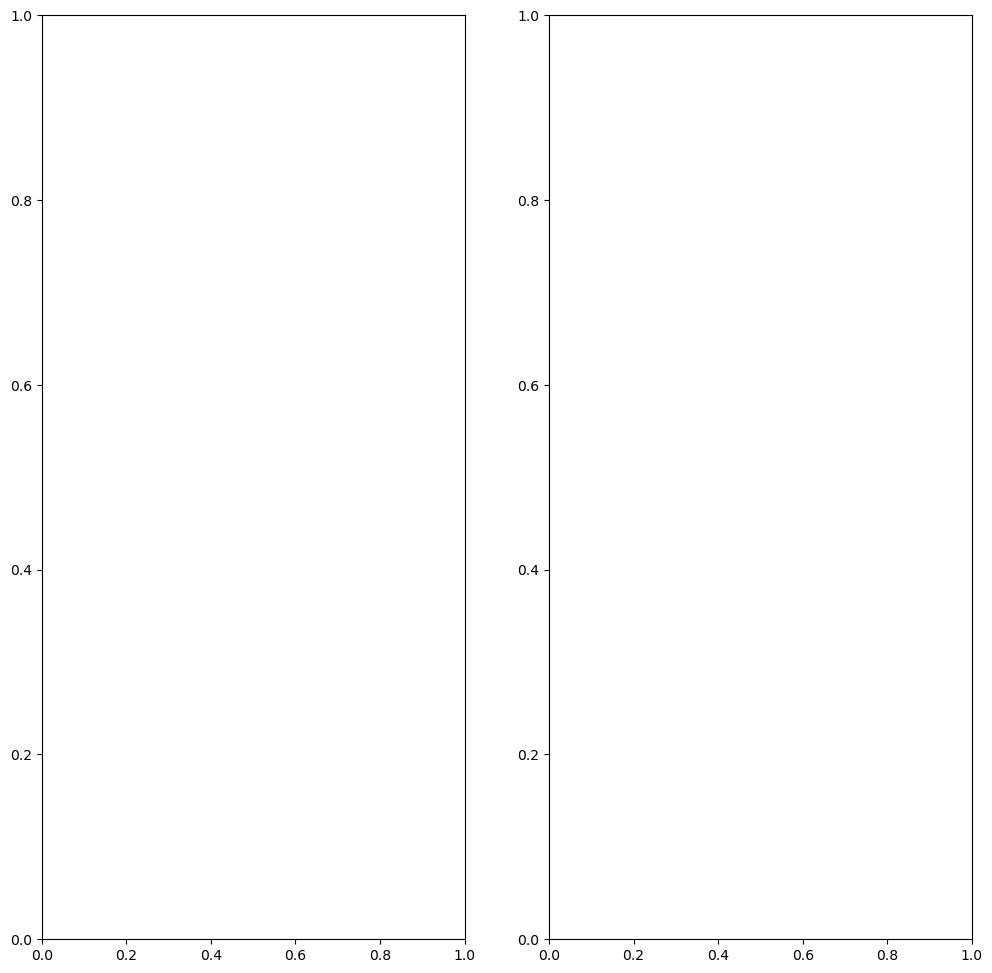

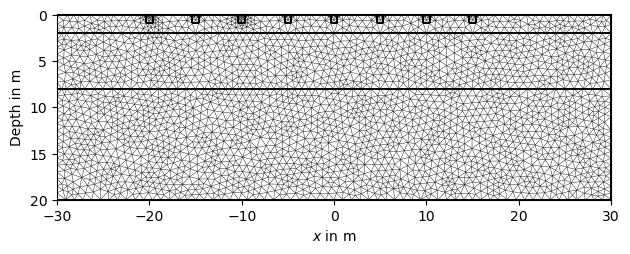

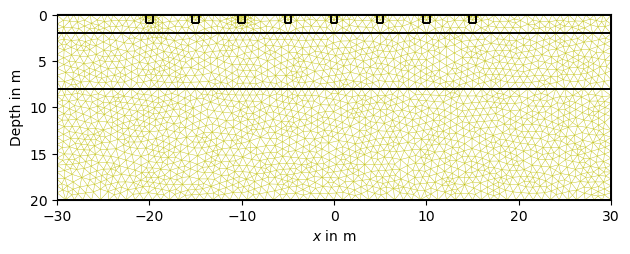

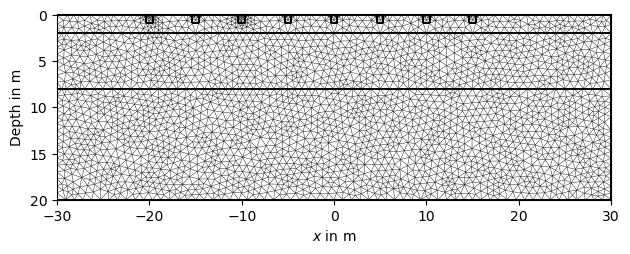

In [17]:
# Determinação da concentração salina por célula do poço
Source_vector = pg.Vector(mesh.cellCount(), 0.0) 
for pos in bores:
    sourceCell = mesh.findCell([pos, prof_poco])
    if sourceCell:
        Source_vector[sourceCell.id()] += TracerCon / sourceCell.size()  # g/(l s) 



fig, axs = plt.subplots(1,2,figsize=(12,12))
axs[0], _ = pg.show(mesh, rhoa=pg.abs(vel) * 1000, cMin=np.min(vel), cMax=np.max(vel),
                label='Velocity $v$ in mm/s', cMap='YlGnBu', hold=True,showStats=True)
axs[0], _ = pg.show(mesh, rhoa=vel, color='y', linewidth=0.6, dropTol=1e-12,
                hold=True)
axs[1], _ = pg.show(mesh, rhoa=Source_vector, label='Concentração salina nas células',cMap='terrain_r')

plt.show()

In [22]:
## Resolução do modelo de ADV DISP

# Create dispersitivity, depending on the absolute velocity
dispersion = pg.abs(vel) * 1e2  # think it is to transform from mm/s to m/s ?

# Solve for injection time, but we need velocities on cell nodes
veln = mt.cellDataToNodeData(mesh, vel)

# Solve without injection starting with last result
c1 = pg.solver.solveFiniteVolume(mesh, a=dispersion, f=Source_vector, vel=veln,
                                 times=t, scheme='PS', verbose=0)
c=1e3*c1

# We can now visualize the result:
# Calculate statistics
mean_c = np.mean(c)
std_c = np.std(c)
min_c = np.min(c)
max_c = np.max(c)
min_c_calc = 0 #mean_c - 1 * std_c
max_c_calc = mean_c + 1 * std_c
print(f"Mean: {mean_c}, Std: {std_c}, Min: {min_c}, Max: {max_c}")

fig, axs= plt.subplots(3,10,figsize=(12,12))
# Visualize the result
for ci in c[0:10][::1]:
    pg.show(mesh, data=ci, cMin=min_c_calc, cMax=max_c_calc, cMap="terrain_r", logScale=True,
            label="Concentration c in g/ml", figsize=(4, 8), orientation='horizontal', axs=[ci])
    


c:\Users\gui\.conda\envs\pg\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


RuntimeError: Factor is exactly singular

In [ ]:
# ERT células de interação
ertScheme = ert.createData(elecs=elecs, schemeName=ERT_Array, spacing=ERT_spac)

meshERT = mt.createParaMesh(ertScheme, quality=mesh_quality, paraMaxCellSize=10, nLayers=1,
boundaryMaxCellSize=7500, smooth=[1, 2])

pg.show(meshERT)

Lei de Archie

$$R_f = R_r (1 - S_w)^m$$
Rf is the fluid resistivity

Rr is the rock resistivity

Sf is the fluid saturation

m is the cementation exponent

In [ ]:
# Simulação elétrica por tempo, concentração e Lei de Archie
timesERT = pg.IVector(np.floor(np.linspace(0, len(c1) - 1, number_of_timesERT)).astype(int)) # Select 10 time frame to simulate ERT data

# Create conductivity of fluid for salt concentration :math:`c`
sigmaFluid = c1[timesERT] * sigma_bx + sigma_a
c1 = np.array(c1)  # Ensure c is a numpy array

# Calculate bulk resistivity based on Archie's Law, by ratio of res water and sigmaFluid
resBulk = petro.resistivityArchie(rFluid = res_water / sigmaFluid, porosity = phi, m=cementation_exponent, mesh=mesh, meshI=meshERT, fill=1)

# apply background resistivity model
rho0 = np.zeros(meshERT.cellCount())

for cell in meshERT.cells():
    if cell.center()[1] < Layer3:
        rho0[cell.id()] = RLayer3
    elif cell.center()[1] < Layer2:
        rho0[cell.id()] = RLayer2
    elif cell.center()[1] < Layer1:
        rho0[cell.id()] = RLayer1
resis = pg.Matrix(resBulk)
for i, rbI in enumerate(resBulk):
    resis[i] = 1. / ((1. / rbI) + 1. / rho0)



In [ ]:
for i in range(len(resis)):
    mean_resis = np.mean(resis[i])
    std_resis = np.std(resis[i])
    min_resis = np.min(resis[i])
    max_resis = np.max(resis[i])
    print(f"Timestep {i+1}:")
    print(f"Mean: {mean_resis}, Std: {std_resis}, Min: {min_resis}, Max: {max_resis},")
    print()

In [ ]:
ERT = ERTManager(verbose=False)

# Run simulation for the apparent resistivities
rhoa = ERT.simulate(meshERT, res=resis, scheme=ertScheme, 
                    returnArray=True, verbose=False,)# noiseLevel=1e-2, noiseAbs=1e-6,)
print('Simulated rhoa', rhoa, np.max(rhoa))

# Its possible that there are some negative data values due to noise and
# huge geometric factors. So we need to remove them
#rhoa.markInvalid(rhoa('rhoa') < 0)
#print('Filtered rhoa', rhoa('rhoa'), max(rhoa('rhoa')))
#rhoa.removeInvalid()

# Optional: save the data for further use
#data.save('simple.dat')

# Calculate statistics for rhoa
#Min_calcERT=mean_rhoa-2*std_rhoa
#Max_calcERT=mean_rhoa+2*std_rhoa 
#cMin=1e-4
#cMax=1

# Plot the first 4 timesteps normalized by the first timestep
# Print the statistics
for i in range(len(rhoa)):

    # Create a copy of the scheme for each visualization
    tempScheme = ertScheme.copy()
    tempScheme.set('rhoa', rhoa[i])
    
    mean_rhoa = np.mean(rhoa[i])
    std_rhoa = np.std(rhoa[i])
    min_rhoa = np.min(rhoa[i])
    max_rhoa = np.max(rhoa[i])
    Min_calcERT=min_rhoa
    Max_calcERT=max_rhoa
    print(f"Timestep {i+1}:")
    print(f"Mean: {mean_rhoa}, Std: {std_rhoa}, Min: {min_rhoa}, Max: {max_rhoa}, Min_calcERT: {Min_calcERT}, Max_calcERT: {Max_calcERT},")
    print()

    # Show the data and get the Axes object
    ax, _ = ERT.showData(tempScheme, vals=rhoa[i],cMin=Min_calcERT,cMax=Max_calcERT,LogScale=True)


    ax.set_ylim(y_limit, ax.get_ylim()[1])  # Set the lower limit Y cut-off

    # Optionally, you can add titles or labels
    ax.set_title(f'Timestep {i+1} normalized by Timestep 1')
    ax.set_xlabel('X-axis label')  # Replace with your actual label
    ax.set_ylabel('Y-axis label')  # Replace with your actual label

    # Show the plot
    plt.show()

In [ ]:
ERT = ERTManager(verbose=False)

# Run simulation for the apparent resistivities
rhoa = ERT.simulate(meshERT, res=resis, scheme=ertScheme, 
                    returnArray=True, verbose=False,)# noiseLevel=1e-2, noiseAbs=1e-6,)
print('Simulated rhoa', rhoa, np.max(rhoa))

# Its possible that there are some negative data values due to noise and
# huge geometric factors. So we need to remove them
#rhoa.markInvalid(rhoa('rhoa') < 0)
#print('Filtered rhoa', rhoa('rhoa'), max(rhoa('rhoa')))
#rhoa.removeInvalid()

# Optional: save the data for further use
#data.save('simple.dat')

# Calculate statistics for rhoa
#Min_calcERT=mean_rhoa-2*std_rhoa
#Max_calcERT=mean_rhoa+2*std_rhoa 
#cMin=1e-4
#cMax=1

# Plot the first 4 timesteps normalized by the first timestep
# Print the statistics
for i in range(len(rhoa)):

    # Create a copy of the scheme for each visualization
    tempScheme = ertScheme.copy()
    tempScheme.set('rhoa', rhoa[i])
    
    mean_rhoa = np.mean(rhoa[i])
    std_rhoa = np.std(rhoa[i])
    min_rhoa = np.min(rhoa[i])
    max_rhoa = np.max(rhoa[i])
    Min_calcERT=min_rhoa
    Max_calcERT=max_rhoa
    print(f"Timestep {i+1}:")
    print(f"Mean: {mean_rhoa}, Std: {std_rhoa}, Min: {min_rhoa}, Max: {max_rhoa}, Min_calcERT: {Min_calcERT}, Max_calcERT: {Max_calcERT},")
    print()

    # Show the data and get the Axes object
    ax, _ = ERT.showData(tempScheme, vals=rhoa[i]/rhoa[0],cMin=Min_calcERT,cMax=Max_calcERT,LogScale=True)

    ax.set_ylim(y_limit, ax.get_ylim()[1])  # Set the lower limit to DD12

    # Optionally, you can add titles or labels
    ax.set_title(f'Timestep {i+1} normalized by Timestep 1')
    ax.set_xlabel('Comprimento em metros')  # Replace with your actual label
    ax.set_ylabel('Y-axis label')  # Replace with your actual label

    # Show the plot
    plt.show()

In [ ]:
#Backup
""" ERT = ERTManager(verbose=False)
# Run  simulation for  the apparent resistivities
rhoa = ERT.simulate(meshERT, res=resis, scheme=ertScheme,
                    returnArray=True, verbose=False)

for i in range(4):
    ERT.showData(ertScheme, vals=rhoa[i]/rhoa[0], logScale=False, label='Apparent resistivity',) """